In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
from datetime import date
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 6)

In [2]:
df = pd.read_csv("KaggleV2-May-2016.csv")
assert df.isnull().sum().sum() == 0, "Missing values found!"
display(df)
df.info()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No
110526,3.775115e+14,5629448,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [3]:
len(df["PatientId"].unique())

def to_date(date_str):
    date_str = date_str.split("-")
    year = date_str[0]
    month = date_str[1]
    day = date_str[2].split("T")[0]
    d = date(int(year), int(month), int(day))
    return d

def to_days(dateobj):
    return int(dateobj.total_seconds() / 86400)
    
df["ScheduledDay"] = df["ScheduledDay"].apply(to_date)
df["AppointmentDay"] = df["AppointmentDay"].apply(to_date)

wait_time = df["AppointmentDay"]-df["ScheduledDay"]
wait_time = wait_time.apply(to_days)
df.insert(0, "WaitTime", wait_time) 
df

,WaitTime,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,0,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,0,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110524,41,1.557663e+13,5630692,F,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,41,9.213493e+13,5630323,F,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,No
110526,41,3.775115e+14,5629448,F,2016-04-27,2016-06-07,54,MARIA ORTIZ,0,0,0,0,0,1,No


## Extract hand-picked features

In [4]:
features_sel_ls = ['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'WaitTime', 'No-show']
df = df[features_sel_ls]
display(df)

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,WaitTime,No-show
0,F,62,0,1,0,0,0,0,0,No
1,M,56,0,0,0,0,0,0,0,No
2,F,62,0,0,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...
110524,F,21,0,0,0,0,0,1,41,No
110525,F,38,0,0,0,0,0,1,41,No
110526,F,54,0,0,0,0,0,1,41,No


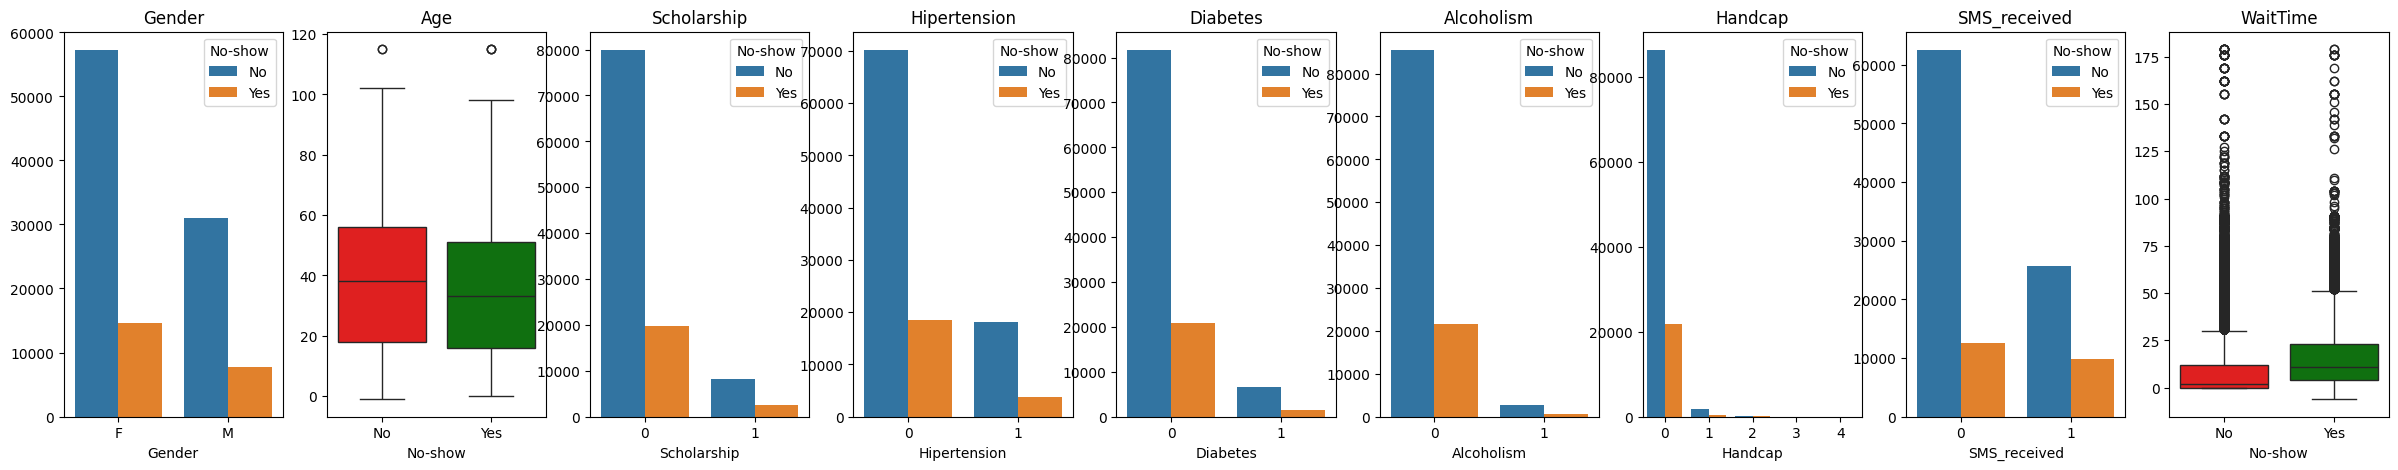

In [5]:
nr_features = len(df.columns.tolist())-1

f, axes = plt.subplots(1, nr_features, figsize=(30, 5))
for fidx in range(nr_features):
    feature_name = df.columns.tolist()[fidx]
    unique_vals = np.unique(df[feature_name])
    if len(unique_vals) > 10:
        g = sns.boxplot(data=df, x="No-show", y=df[feature_name], hue="No-show", palette=['r','g'],ax=axes[fidx])
    else:
        g = sns.countplot(data=df, x=feature_name, hue="No-show",ax=axes[fidx])
    g.set(ylabel=None, title= feature_name);
    g.set(ylabel=None, title= feature_name);

#plt.savefig("Selected_Features_ViolinPlot.png")

## Encode and Scale Features and Target

In [6]:
## Encode and Scale Features and Target
df.loc[:,"Gender"] = df[["Gender"]] == "M"
df = df.astype({'Gender': 'int32'})
df.loc[:,"Age"] = MinMaxScaler().fit_transform(df[["Age"]].values)
df.loc[:,"WaitTime"] = MinMaxScaler().fit_transform(df[["WaitTime"]].values)
df.loc[:,"Handcap"] = df[["Handcap"]].values > 0
df = df.astype({'Handcap': 'int32'})
df.loc[:,"No-show"] = LabelEncoder().fit_transform(df[["No-show"]].values.ravel())
df = df.astype({'No-show': 'int32'})

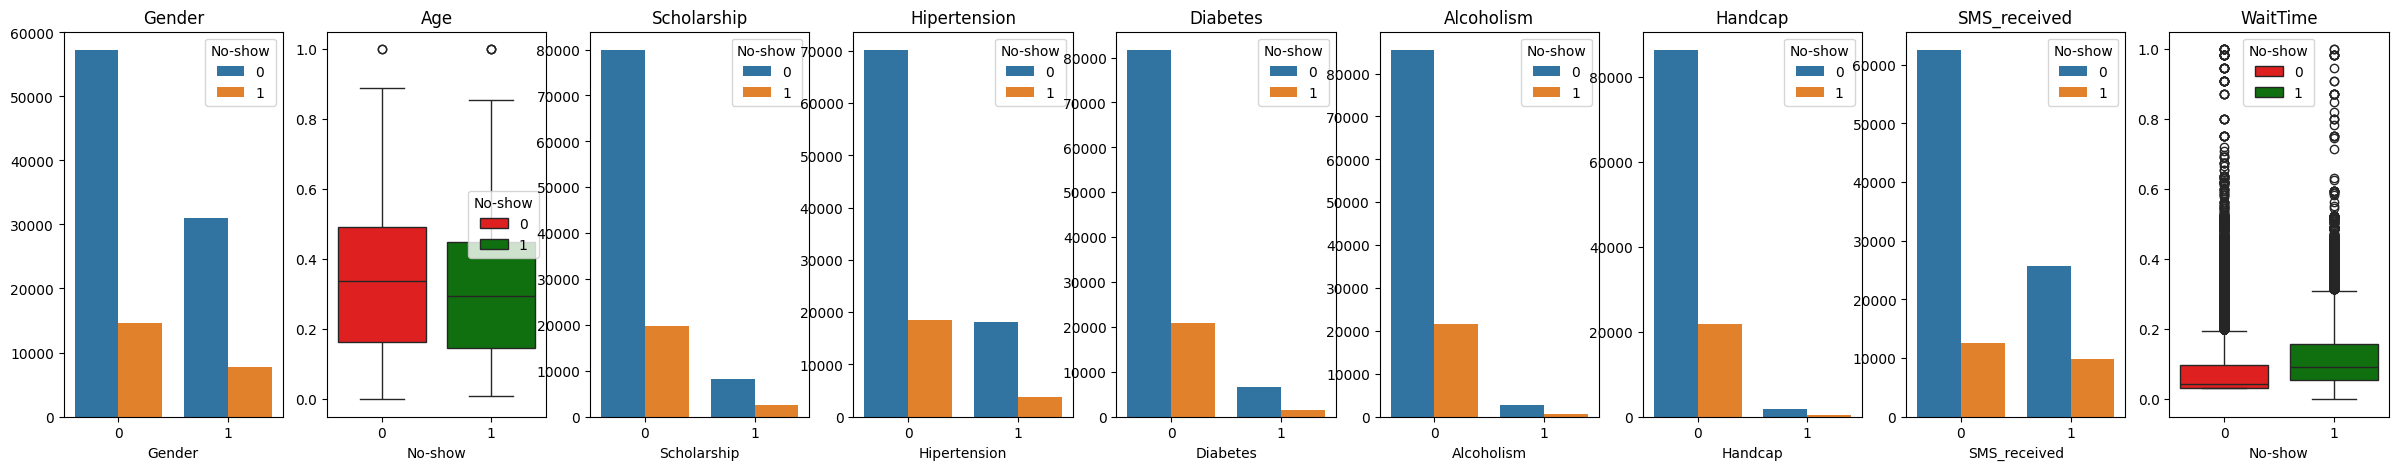

In [7]:
f, axes = plt.subplots(1, nr_features, figsize=(30, 5))
for fidx in range(nr_features):
    feature_name = df.columns.tolist()[fidx]
    unique_vals = np.unique(df[feature_name])
    if len(unique_vals) > 10:
        g = sns.boxplot(data=df, x="No-show", y=df[feature_name], hue="No-show", palette=['r','g'],ax=axes[fidx])
    else:
        g = sns.countplot(data=df, x=feature_name, hue="No-show",ax=axes[fidx])
    g.set(ylabel=None, title= feature_name);
    g.set(ylabel=None, title= feature_name);

#plt.savefig("Selected_Features_ViolinPlot.png")

In [8]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

assert X.isnull().sum().sum() == 0, "Missing values found!"
assert y.isnull().sum().sum() == 0, "Missing values found!"

print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Gender        110527 non-null  int32  
 1   Age           110527 non-null  float64
 2   Scholarship   110527 non-null  int64  
 3   Hipertension  110527 non-null  int64  
 4   Diabetes      110527 non-null  int64  
 5   Alcoholism    110527 non-null  int64  
 6   Handcap       110527 non-null  int32  
 7   SMS_received  110527 non-null  int64  
 8   WaitTime      110527 non-null  float64
dtypes: float64(2), int32(2), int64(5)
memory usage: 6.7 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 110527 entries, 0 to 110526
Series name: No-show
Non-Null Count   Dtype
--------------   -----
110527 non-null  int32
dtypes: int32(1)
memory usage: 431.9 KB
None


In [9]:
feature_names = X.columns
X = X.values
y = y.values.ravel()
print(X.shape)
print(y.shape)

(110527, 9)
(110527,)


## Partition data into Training, Validation and Test sets

In [10]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Get Test and Training sets
X_positives = X[y>0,:]
y_positives = y[y>0]
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_positives, y_positives, test_size=0.2, random_state=0)

X_negatives = X[y<=0,:]
y_negatives = y[y<=0]
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_negatives, y_negatives, test_size=0.2, random_state=0)

X_test = np.vstack((X_test_p, X_test_n))
y_test = np.hstack((y_test_p, y_test_n))

X_train = np.vstack((X_train_p, X_train_n))
y_train = np.hstack((y_train_p, y_train_n))

# Get Validation and Training sets
X_positives = X_train[y_train>0,:]
y_positives = y_train[y_train>0]
X_train_p, X_valid_p, y_train_p, y_valid_p = train_test_split(X_positives, y_positives, test_size=0.2, random_state=0)

X_negatives = X_train[y_train<=0,:]
y_negatives = y_train[y_train<=0]
X_train_n, X_valid_n, y_train_n, y_valid_n = train_test_split(X_negatives, y_negatives, test_size=0.2, random_state=0)

X_validation = np.vstack((X_valid_p, X_valid_n))
y_validation = np.hstack((y_valid_p, y_valid_n))

X_train = np.vstack((X_train_p, X_train_n))
y_train = np.hstack((y_train_p, y_train_n))

#rd.sample(sum(y), len(y)*0.2)

In [11]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_validation, y_validation = sm.fit_resample(X_validation, y_validation)

In [12]:
len(X_train)

112904

# Train and validate model using Optuna

In [13]:
random_state=50

In [14]:
def objective(trial):
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 10, 250, step = 10),
    "max_depth": trial.suggest_int("max_depth", 1, 20),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
    "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
    "random_state": random_state,
    }
    
    model = RandomForestClassifier(**params).fit(X_train, y_train)

    y_predicted = model.predict(X_validation)
    (tn, fp, fn, tp) = confusion_matrix(y_validation, y_predicted).ravel()
    accuracy_val = float(tp+tn)/float(tn+fp+fn+tp)
    
    return accuracy_val


In [ ]:
start_time = time.time()

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials=500)

total_time = time.time()-start_time
print(f"total_time={total_time}")
print(study.best_params)
print(study.best_value)

[I 2023-12-20 20:52:45,486] A new study created in memory with name: no-name-acbecd57-7a42-4ef0-804f-7aea4f8c925c
[I 2023-12-20 20:52:51,434] Trial 0 finished with value: 0.6843205328043078 and parameters: {'n_estimators': 130, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6843205328043078.
[I 2023-12-20 20:52:55,370] Trial 1 finished with value: 0.6815927447924047 and parameters: {'n_estimators': 110, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 0 with value: 0.6843205328043078.
[I 2023-12-20 20:52:59,358] Trial 2 finished with value: 0.7343417882953096 and parameters: {'n_estimators': 40, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 2 with value: 0.7343417882953096.
[I 2023-12-20 20:53:09,087] Trial 3 finished with value: 0.7167351565821171 and parameters: {'n_estimators': 140, 'max_depth': 11, 'min_s

In [ ]:
best_n_estimators = study.best_params["n_estimators"]
best_criterion = study.best_params["criterion"]
best_max_depth = study.best_params["max_depth"]
best_min_split = study.best_params["min_samples_split"]
best_min_leaf = study.best_params["min_samples_leaf"]

In [ ]:
model = RandomForestClassifier(n_estimators=best_n_estimators, criterion=best_criterion, 
                               max_depth=best_max_depth, min_samples_split=best_min_split,
                               min_samples_leaf=best_min_leaf,random_state=random_state)

## Run on the test set and use training and validation sets for training

In [ ]:
X_train_valid = np.concatenate((X_train, X_validation))
y_train_valid = np.concatenate((y_train, y_validation))

model.fit(X_train_valid, y_train_valid)
print(model.score(X_test, y_test))
y_predicted = model.predict(X_test)

(tn, fp, fn, tp) = confusion_matrix(y_test, y_predicted).ravel()
precision_val = float(tp)/float(tp+fp)
recall_val = float(tp)/float(tp+fn)
specificity_val = float(tn)/float(tn+fp)
accuracy_val = float(tp+tn)/float(tn+fp+fn+tp)
f1_val = (2*tp)/(2*tp+fp+fn)
mcc_val = float((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


print("\n")
print("Test set precision_val =", precision_val)
print("Test set recall_val =", recall_val)
print("Test set sspecificity =", specificity_val)
print("Test set mcc_val =", mcc_val)
print("Test set accuracy_val =", accuracy_val)
print("Test set f1_val =", f1_val)

In [ ]:
confusion_matrix(y_test, y_predicted)

In [ ]:
y_test

In [ ]:
importances = model.feature_importances_
print(importances)
# feature_names_in_ only defined if the X input to fit() is a dataframe and the column names are all strings
#features_names = model.feature_names_in_
#print(features_names)

In [ ]:
print(max(importances))
print(min(importances))
print(sum(importances))